## <font color= "DeepPink">疑問点
- テストデータにたげ欠損値（0~4）ある場合の処理
- テストデータとトレインデータにデータ型の違いがあるとき
- metrics.mean_squareとscoring="neg_mean_squared_error"の違い

## <font color= "DeepPink">解明点
- 入れ子式のgridserachは他手法との比較にしか使えない
- グリッドサーチ自身もモデルである
- モデルに追加学習は基本出来ない➡k-foldで学習してモデルを作成する場合、for文で回し5個のモデルを作成し、その予測の平均値を答えとするしかない


# <font color= "DeepPink">1.下準備

### 前提
- 回帰
- モデルの評価指標➡RMSE


### ライブラリのインポート

In [1]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!unzip "/content/drive/My Drive/00Colab Notebooks/11Kaggle/House prices/house-prices-advanced-regression-techniques.zip"

Archive:  /content/drive/My Drive/00Colab Notebooks/11Kaggle/House prices/house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [7]:
# 基本
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
%matplotlib inline

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

#モデルの評価
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#サイパイ、相関係数
from scipy.stats import norm
from scipy import stats

#モデル
import xgboost as xgb 
from xgboost import XGBRegressor
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet
)

#ワーニング
import warnings
warnings.filterwarnings('ignore')



### データの読み込み

In [40]:
import os
DIR = ''
df_train_origin = pd.read_csv(os.path.join(DIR, 'train.csv'))
df_train = df_train_origin.copy()

#正解ラベルなしtestデータ
df_test_origin = pd.read_csv(os.path.join(DIR, 'test.csv'))
df_test = df_test_origin.copy()

df_sub = pd.read_csv(os.path.join(DIR, 'sample_submission.csv'))

In [44]:
!pip install pycaret

     |████████████████████████████████| 256kB 4.4MB/s 
     |████████████████████████████████| 13.9MB 225kB/s 
     |████████████████████████████████| 1.8MB 45.8MB/s 
     |████████████████████████████████| 6.8MB 43.0MB/s 
     |████████████████████████████████| 276kB 46.4MB/s 
     |████████████████████████████████| 174kB 40.8MB/s 
     |████████████████████████████████| 1.6MB 42.6MB/s 
     |████████████████████████████████| 148.9MB 70kB/s 
     |████████████████████████████████| 66.2MB 61kB/s 
     |████████████████████████████████| 266kB 29.7MB/s 
     |████████████████████████████████| 102kB 6.7MB/s 
     |████████████████████████████████| 6.0MB 31.9MB/s 
     |████████████████████████████████| 153kB 40.0MB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
     |████████████████████████████████| 1.1MB 36.4MB/s 
     |████████████████████████████████| 163kB 44.8MB/s 
     |████████████████████████████████| 327kB 44.6MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 

In [42]:
import pandas as pd
from pycaret.regression import *

ModuleNotFoundError: ignored

In [10]:
#ターゲットカラムの特定、(共通しないカラムの抽出)
targets = list(set(df_train.columns) ^ set(df_test.columns))
print(targets)
target = targets[0]
print(df_train.shape,df_test.shape)

['SalePrice']
(1460, 81) (1459, 80)


In [11]:
#回帰なら数字、分類なら文字列
df_test[target] = 9999999999
# 学習データとテストデータのマージ
df_train['WhatIsData'] = 'Train'
df_test['WhatIsData'] = 'Test'
#df_allの生成
df_all = pd.concat([df_train,df_test],axis=0).reset_index(drop=True)
print(df_all.shape)

(2919, 82)


# <font color= "DeepPink">2.データの概要（欠損地、外れ値、分布の確認）

### targetの確認

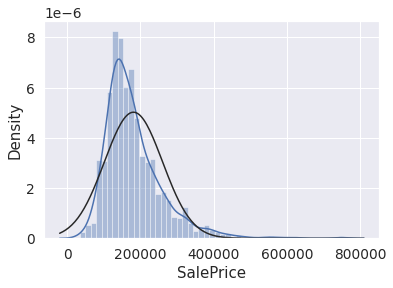

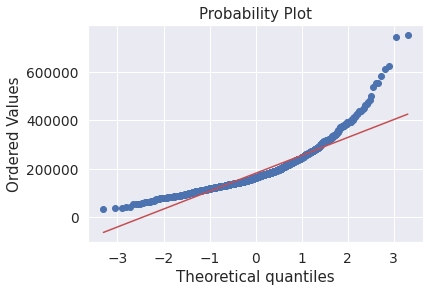

In [45]:
sns.distplot(df_train[target], fit = norm)
fig = plt.figure()
res = stats.probplot(df_train[target],plot=plt)


In [13]:
#歪度と尖度
print("Skewness: %f" % df_train[target].skew())
print("Kurtosis: %f" % df_train[target].kurt())
df_train[target].describe()

Skewness: 1.882876
Kurtosis: 6.536282


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

### df_train

In [14]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,WhatIsData
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,Train
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,Train
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,Train
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,Train
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,Train


In [15]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [16]:
#dtypesの確認
print(pd.Series(df_train.dtypes).value_counts())
print(pd.Series(df_test.dtypes).value_counts())

object     44
int64      35
float64     3
dtype: int64
object     44
int64      27
float64    11
dtype: int64


In [17]:
#trainとtestのdtypeの齟齬,データを結合するとintはfloatに引っ張られる。
for i,j in zip(df_train.dtypes.items(),df_test.dtypes.items()):
  if i[0] != j[0]:
    print("カラムの順番違うよ",i,j)
  elif i[1]!=j[1]:
    print("train:",i,"  test:",j)

train: ('BsmtFinSF1', dtype('int64'))   test: ('BsmtFinSF1', dtype('float64'))
train: ('BsmtFinSF2', dtype('int64'))   test: ('BsmtFinSF2', dtype('float64'))
train: ('BsmtUnfSF', dtype('int64'))   test: ('BsmtUnfSF', dtype('float64'))
train: ('TotalBsmtSF', dtype('int64'))   test: ('TotalBsmtSF', dtype('float64'))
train: ('BsmtFullBath', dtype('int64'))   test: ('BsmtFullBath', dtype('float64'))
train: ('BsmtHalfBath', dtype('int64'))   test: ('BsmtHalfBath', dtype('float64'))
train: ('GarageCars', dtype('int64'))   test: ('GarageCars', dtype('float64'))
train: ('GarageArea', dtype('int64'))   test: ('GarageArea', dtype('float64'))


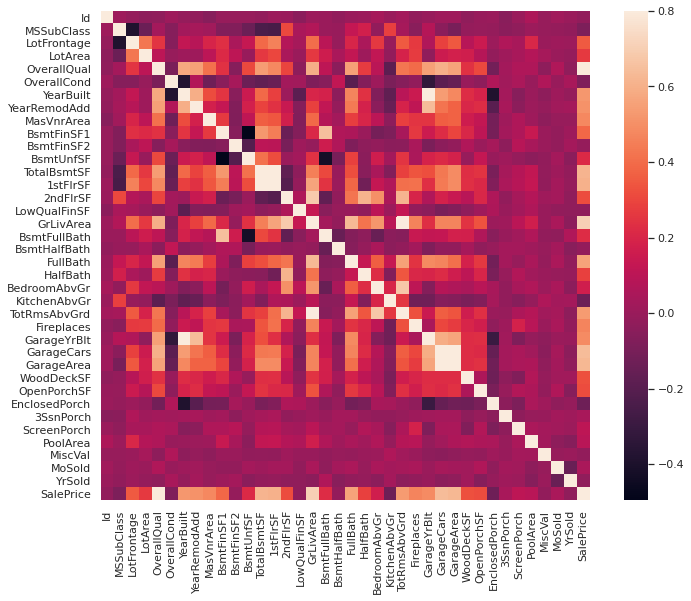

In [18]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

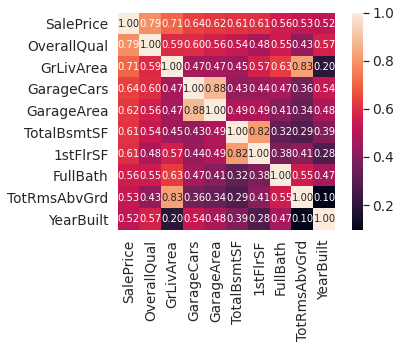

In [19]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, target)[target].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

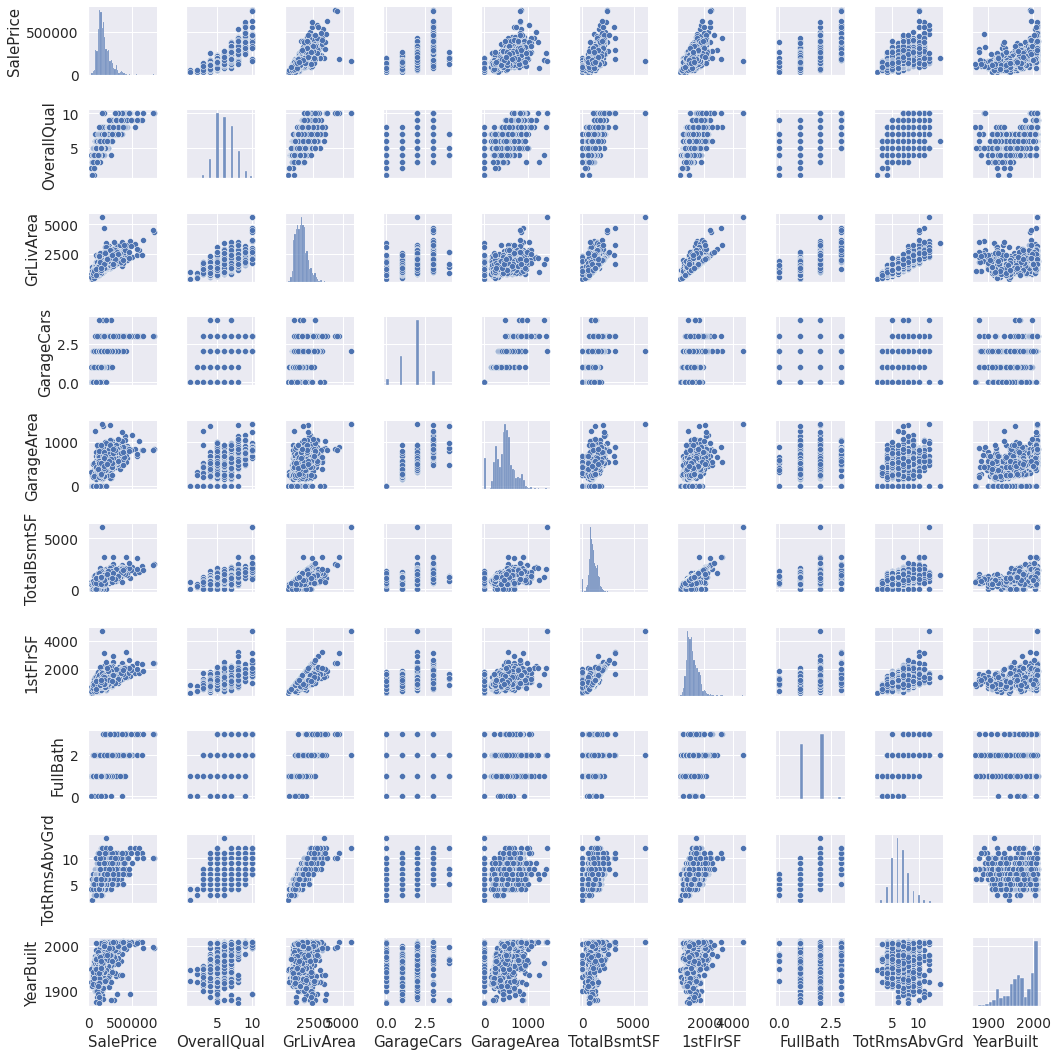

In [20]:
#ターゲットと相関の強い上位10カラム（ターゲット含み１０個）
cols = list(cols)
sns.pairplot(df_train[cols], size = 1.5)
plt.show()

### Missing data

In [21]:
# 欠損地一つ以上のカラム
total_train = df_train.isnull().sum()
total_test = df_test.isnull().sum()
percent_train = (df_train.isnull().sum()/df_train.isnull().count())
percent_test = (df_test.isnull().sum()/df_test.isnull().count())
missing_data = pd.concat([total_train,total_test, percent_train, percent_test], axis=1, keys=['Total_train','Total_test', 'Percent_train',  'Percent_test'])
missing_data[(missing_data["Total_train"]>0) | (missing_data["Total_test"]>0)].sort_values("Total_train",ascending=False)

,Total_train,Total_test,Percent_train,Percent_test
PoolQC,1453,1456,0.995205,0.997944
MiscFeature,1406,1408,0.963014,0.965045
Alley,1369,1352,0.937671,0.926662
Fence,1179,1169,0.807534,0.801234
FireplaceQu,690,730,0.472603,0.500343
LotFrontage,259,227,0.177397,0.155586
GarageType,81,76,0.055479,0.052090
GarageCond,81,78,0.055479,0.053461
GarageYrBlt,81,78,0.055479,0.053461
GarageFinish,81,78,0.055479,0.053461


### Out liars

In [22]:
#targetを標準化して、上位１０個と下位１０個のデータを確認
scaled_train = StandardScaler().fit_transform(df_train[target][:,np.newaxis]);
low_range = scaled_train[scaled_train[:,0].argsort()][:10]
high_range= scaled_train[scaled_train[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

outer range (high) of the distribution:
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


# <font color= "DeepPink">3.特徴量エンジニアリング

In [23]:
df_train.MiscFeature.head(50)

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
5     Shed
6      NaN
7     Shed
8      NaN
9      NaN
10     NaN
11     NaN
12     NaN
13     NaN
14     NaN
15     NaN
16    Shed
17    Shed
18     NaN
19     NaN
20     NaN
21     NaN
22     NaN
23     NaN
24     NaN
25     NaN
26     NaN
27     NaN
28     NaN
29     NaN
30     NaN
31     NaN
32     NaN
33     NaN
34     NaN
35     NaN
36     NaN
37     NaN
38     NaN
39     NaN
40     NaN
41     NaN
42     NaN
43     NaN
44     NaN
45     NaN
46     NaN
47     NaN
48     NaN
49     NaN
Name: MiscFeature, dtype: object

### 欠損値の処理

In [24]:
# 欠損を含むカラムをリスト化
na_col_list = df_all.isnull().sum()[df_all.isnull().sum()>0].index.tolist()
df_all[na_col_list].dtypes.sort_values()

TotalBsmtSF     float64
BsmtUnfSF       float64
BsmtFinSF2      float64
BsmtFinSF1      float64
GarageYrBlt     float64
BsmtFullBath    float64
GarageCars      float64
BsmtHalfBath    float64
GarageArea      float64
LotFrontage     float64
MasVnrArea      float64
GarageQual       object
GarageCond       object
GarageType       object
PoolQC           object
FireplaceQu      object
Fence            object
Functional       object
KitchenQual      object
GarageFinish     object
MSZoning         object
MiscFeature      object
BsmtFinType2     object
BsmtFinType1     object
BsmtExposure     object
BsmtCond         object
BsmtQual         object
MasVnrType       object
Exterior2nd      object
Exterior1st      object
Utilities        object
Alley            object
Electrical       object
SaleType         object
dtype: object

In [25]:
# データ型に応じて欠損値を補完する
# floatの場合は0
# objectの場合は'NA'
na_float_cols = df_all[na_col_list].dtypes[df_all[na_col_list].dtypes=='float64'].index.tolist() #float64
na_obj_cols = df_all[na_col_list].dtypes[df_all[na_col_list].dtypes=='object'].index.tolist() #object
for i in na_float_cols:
  if 0 in df_all[i].unique():
    print("float:",i)
for i in na_obj_cols:
  if "NA" in df_all[i].unique():
    print("object:",i)

float: MasVnrArea
float: BsmtFinSF1
float: BsmtFinSF2
float: BsmtUnfSF
float: TotalBsmtSF
float: BsmtFullBath
float: BsmtHalfBath
float: GarageCars
float: GarageArea


In [26]:
# float64型で欠損している場合は0を代入
for na_float_col in na_float_cols:
    df_all.loc[df_all[na_float_col].isnull(),na_float_col] = 0.0
# object型で欠損している場合は'NA'を代入
for na_obj_col in na_obj_cols:
    df_all.loc[df_all[na_obj_col].isnull(),na_obj_col] = 'NA'

In [27]:
# マージデータの欠損状況
df_all.isnull().sum()[df_all.isnull().sum()>0].sort_values(ascending=False)

Series([], dtype: int64)

### 必要カラムの抽出と、カテゴリカルカラムのダミー化、

In [28]:
# カテゴリカル変数の特徴量をリスト化
cat_cols = df_all.dtypes[df_all.dtypes=='object'].index.tolist()
# 数値変数の特徴量をリスト化
num_cols = df_all.dtypes[df_all.dtypes!='object'].index.tolist()

# データ分割および提出時に必要なカラムをリスト化
other_cols = ['Id','WhatIsData']
# 余計な要素をリストから削除
cat_cols.remove('WhatIsData') #学習データ・テストデータ区別フラグ除去
num_cols.remove('Id') #Id削除
# カテゴリカル変数をダミー化
df_all_cat = pd.get_dummies(df_all[cat_cols])
# データ統合
df_all = pd.concat([df_all[other_cols],df_all[num_cols],df_all_cat],axis=1)

### train、testへの再分割

In [29]:
# マージデータを学習データとテストデータに分割
df_train = df_all[df_all['WhatIsData']=='Train'].drop(['WhatIsData','Id'], axis=1).reset_index(drop=True)
df_test = df_all[df_all['WhatIsData']=='Test'].drop(['WhatIsData','SalePrice'], axis=1).reset_index(drop=True)

### trainの外れ値の処理

In [30]:
#元のtrainのshapeを確認
print("train_shape",df_train.shape)
#二元配列化
out_liars = df_train[target][:,np.newaxis]
#大きい値から二番目までをリスト化➡[-2:]
out_liars = out_liars[out_liars[:,0].argsort()][-2:]
#二元配列を一元に展開
out_liars = out_liars.flatten()
out_liars

train_shape (1460, 312)


array([745000, 755000])

In [31]:
#外れ値の削除
for i in out_liars:
  df_train = df_train[df_train[target] != i]
df_train.shape

(1458, 312)

### トレインデータのtrain、t-testへの分割。yラベルの対数変換（スケイリングは決定木のため割愛）

In [32]:
#trainデータのtrain、testへの分割 ※yラベルは対数変換！！！
train_set,test_set = train_test_split(df_train,test_size= 0.3,random_state=1)
X_train = train_set.drop(target,axis=1)
y_train = np.log(train_set[target].copy())
X_test = test_set.drop(target,axis=1)
y_test = np.log(test_set[target].copy())

# 未知のテストデータ内の分割
test_id = df_test['Id']
test_data = df_test.drop('Id',axis=1)

In [33]:
#k-fold学習用のデータ➡テストデータなし。
X_kfold = df_train.drop(target,axis=1)
y_kfold = np.log(df_train[target].copy())

# <font color= "DeepPink">4.モデルの作成
- モデル自身にスコアタイプが保存できる
- grid_searchもlearning_curveもモデルの一つ

### 他モデルとの比較 ➡GridSearch with k-fold

In [37]:
%%time
#xgboost➡決定木の本数、学習率
model = XGBRegressor(seed = 42)
test_params = {
    "n_estimators":[400,500],
    "learning_rate":[.01, .001]
}

#グリッドサーチ                              
gridsearch = GridSearchCV(estimator=model
,scoring="r2",param_grid=test_params,cv=2,return_train_score = False)

#パイプラインへの組み込み(標準化＋グリッドサーチ)
gridsearch_pipe = make_pipeline(gridsearch)
gridsearch_pipe.fit(X_kfold, y_kfold)
print("ベストパラム:",gridsearch.best_params_)

#beset_paramsを使用した交差検証
kfold = KFold(n_splits=4)
scores = cross_val_score(gridsearch_pipe, X_kfold, y_kfold,cv=kfold,scoring="r2")
print("ベストパラム:",gridsearch.best_params_)
print('CV 精度: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

[11:00:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:00:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [38]:
%%time
##Lasso回帰➡alpha
model = Lasso()
test_params = {
    "alpha":[0.001, 0.01, 0.1, 1.0, 10.0,100.0,1000.0],
}

#グリッドサーチ                              
gridsearch = GridSearchCV(estimator=model
,scoring="r2",param_grid=test_params,cv=2,return_train_score = False)

#パイプラインへの組み込み(標準化＋グリッドサーチ)
gridsearch_pipe = make_pipeline(StandardScaler(),gridsearch)
gridsearch_pipe.fit(X_kfold, y_kfold)
print("ベストパラム:",gridsearch.best_params_)

#beset_paramsを使用した交差検証
kfold = KFold(n_splits=4)
scores = cross_val_score(gridsearch_pipe, X_kfold, y_kfold,cv=kfold,scoring="r2")
print('CV 精度: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

ベストパラム: {'alpha': 0.01}
CV 精度: 0.863 +/- 0.052
CPU times: user 1.33 s, sys: 993 ms, total: 2.33 s
Wall time: 1.21 s


In [39]:
%%time
#Elasticnet➡alpha(L1,L2の大きさ),ratio(L1正則化項の割合)
model = ElasticNet()
test_params = {
    "alpha":[0.001, 0.01, 0.1, 1.0, 10.0,100.0,1000.0],
    "l1_ratio":[0.1, 0.2, 0.3, 0.4,0.5, 0.6, 0.7, 0.8,0.9]
}

#グリッドサーチ                              
gridsearch = GridSearchCV(estimator=model
,scoring="r2",param_grid=test_params,cv=2,return_train_score = False)

#パイプラインへの組み込み(標準化＋グリッドサーチ)
gridsearch_pipe = make_pipeline(StandardScaler(),gridsearch)
gridsearch_pipe.fit(X_kfold, y_kfold)
print("ベストパラム:",gridsearch.best_params_)

#beset_paramsを使用した交差検証
kfold = KFold(n_splits=4)
scores = cross_val_score(gridsearch_pipe, X_kfold, y_kfold,cv=kfold,scoring="r2")
print('CV 精度: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

ベストパラム: {'alpha': 0.1, 'l1_ratio': 0.1}
CV 精度: 0.870 +/- 0.047
CPU times: user 16.7 s, sys: 11.5 s, total: 28.2 s
Wall time: 14.6 s


### ベースモデルの作成

In [ ]:
xgboost_base = XGBRegressor(scoring = "r2")
model_results = xgboost_base.fit(X_train,y_train)

[06:36:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
xgboost_base.evals_result()

AttributeError: ignored

In [ ]:
model_results.evals_result()

AttributeError: ignored

In [ ]:
# 予測
y_pred_train = xgboost_base.predict(X_train)
y_pred_test = xgboost_base.predict(X_test)
# MSE、r2（RMSEだとある程度小さくなると0になってしまうので）
print("対トレイン",mean_squared_error(y_pred_train,y_train),r2_score(y_pred_train,y_train))
print("対テスト",mean_squared_error(y_pred_test,y_test),r2_score(y_pred_test,y_test))

対トレイン 0.006108846751212123 0.9576778813145655
対テスト 0.017674397914581495 0.8708161030349163


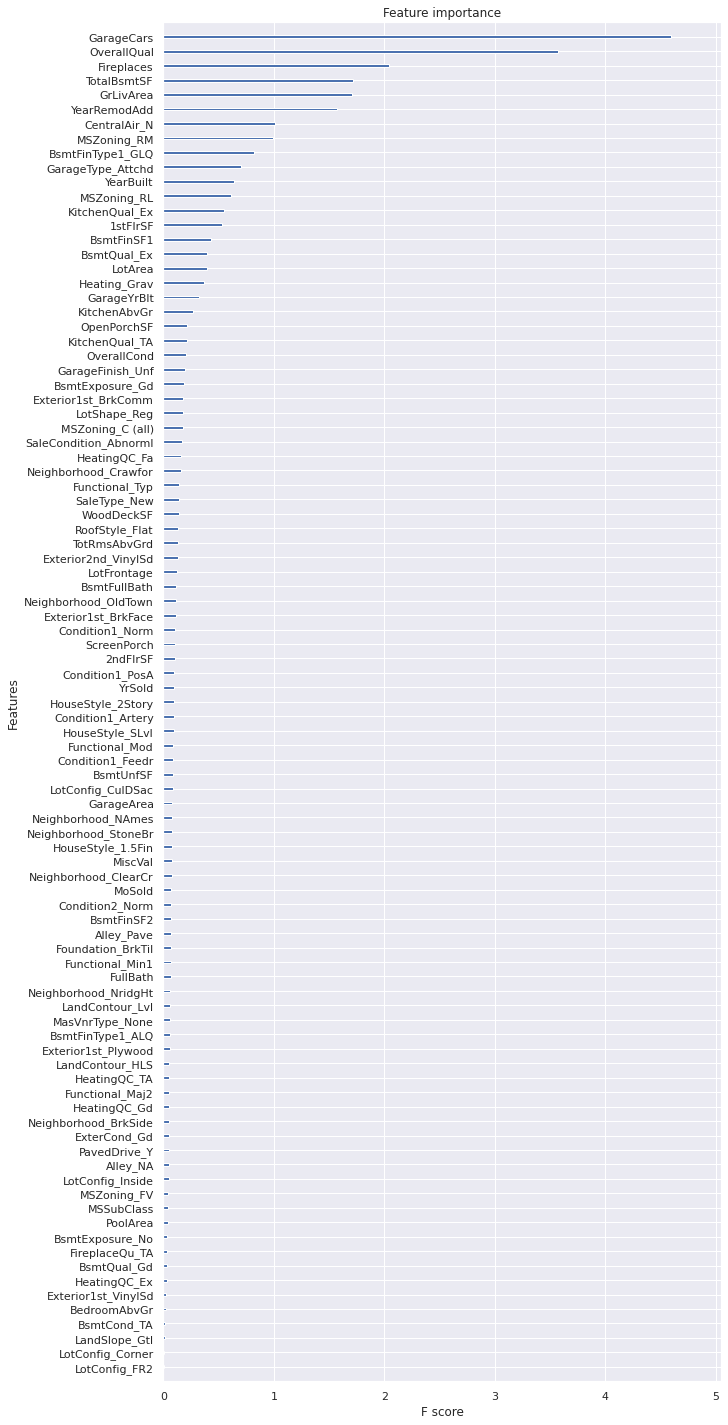

In [ ]:
# future_impotance_plots
_, ax = plt.subplots(figsize=(10, 25))
xgb.plot_importance(xgboost_base, ax=ax, importance_type="gain", show_values=False)
plt.show()

In [ ]:
#feature_importances_の上位ｎ件
features = X_train.columns
importances = xgboost_base.feature_importances_
imp=sorted(zip(map(lambda x:round(x,2),importances),features),reverse=True)
#上位10件の表示
print(imp[:10])

[(0.15, 'GarageCars'), (0.12, 'OverallQual'), (0.07, 'Fireplaces'), (0.06, 'TotalBsmtSF'), (0.06, 'GrLivArea'), (0.05, 'YearRemodAdd'), (0.03, 'MSZoning_RM'), (0.03, 'CentralAir_N'), (0.03, 'BsmtFinType1_GLQ'), (0.02, 'YearBuilt')]


### 学習曲線(あくまで検証、学習ではない)

In [ ]:
#score = R2
def learning_curve_plot(model,X_train,y_train):
  from sklearn.model_selection import learning_curve
  train_sizes, train_scores, test_scores =\
                  learning_curve(estimator=model,
                                X=X_train,
                                y=y_train,
                                train_sizes=np.linspace(0.1, 1.0, 10),
                                cv=10,
                                scoring="r2",
                                n_jobs=-1)

  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)
  test_mean = np.mean(test_scores, axis=1)
  test_std = np.std(test_scores, axis=1)

  plt.plot(train_sizes, train_mean,
          color='blue', marker='o',
          markersize=5, label='training scroe')

  plt.fill_between(train_sizes,
                  train_mean + train_std,
                  train_mean - train_std,
                  alpha=0.15, color='blue')

  plt.plot(train_sizes, test_mean,
          color='green', linestyle='--',
          marker='s', markersize=5,
          label='validation score')

  plt.fill_between(train_sizes,
                  test_mean + test_std,
                  test_mean - test_std,
                  alpha=0.15, color='green')

  plt.grid()
  plt.xlabel('Number of training samples')
  plt.ylabel('score')
  plt.legend(loc='lower right')
  # plt.ylim([0.8, 1.03])
  plt.tight_layout()
  #plt.savefig('images/06_05.png', dpi=300)
  plt.show()

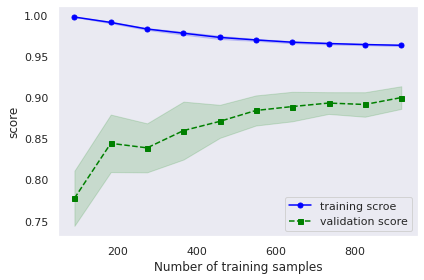

In [ ]:
  pipe_lr = make_pipeline(XGBRegressor())
  learning_curve_plot(pipe_lr,X_train,y_train)

In [ ]:
# 交差検証(kfold)
metrics = ["neg_mean_squared_error","explained_variance","r2","neg_root_mean_squared_error"]
kfold = KFold(n_splits=4)
# xgboost_baseを入れても同じこと➡一から学習しなおしている(学習は引き継がない),データはX_kfold分割なしを使う
cross_validate(XGBRegressor(), X_kfold, y_kfold,cv=kfold,scoring=metrics)

[12:49:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:49:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:49:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:49:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'fit_time': array([0.64736581, 0.61846018, 0.64860845, 0.63223219]),
 'score_time': array([0.00855041, 0.00777125, 0.00784087, 0.00770211]),
 'test_explained_variance': array([0.91995671, 0.8798857 , 0.88833086, 0.89237102]),
 'test_neg_mean_squared_error': array([-0.01255976, -0.02247408, -0.01604102, -0.01524961]),
 'test_neg_root_mean_squared_error': array([-0.11207034, -0.14991358, -0.12665315, -0.1234893 ]),
 'test_r2': array([0.91890909, 0.87864422, 0.88826718, 0.89230925])}

In [ ]:
#実際の値の比較
y_pred_train = xgboost_base.predict(X_train)
y_pred_test = xgboost_base.predict(X_test)
print(np.log(y_pred_test[0:5]))
print(np.log(y_test[0:5].values))

[2.4727414 2.4925263 2.464806  2.4987676 2.4723008]
[2.45089535 2.4932643  2.47167189 2.49069652 2.46729897]


### GridSearch(一回実行した後は、printされたものを使った方がいい)

In [ ]:
#決定木の本数の調整
test_params = {
    "n_estimators":[400,500,600,700,800,900,1000]
}

In [ ]:
%%time
gridsearch1 = GridSearchCV(estimator=XGBRegressor(seed = 42)
,scoring="r2",param_grid=test_params,cv=3,return_train_score = False)
gridsearch1.fit(X_train,y_train)

[02:18:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:18:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:18:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:18:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:18:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:18:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:18:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:18:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
best_params = {}
best_params.update(gridsearch1.best_params_)
best_params

{'n_estimators': 900}

In [ ]:
gridsearch1.cv_results_["mean_test_score"]

array([0.90173732, 0.90207332, 0.90238785, 0.90274822, 0.90273642,
       0.90284357, 0.90277699])

In [ ]:
#max_depthとmin_child_weightの調整
%%time
initial_params = best_params

test_params = {
    "max_depth":[2,3,4,6,10],
    "min_child_weight":[1,2,3,4,6,10]
}

gridsearch2 = GridSearchCV(estimator=XGBRegressor(**initial_params,seed=42),
                           param_grid = test_params,scoring ="explained_variance",
                           cv=5,return_train_score = False)
gridsearch2.fit(X_train,y_train)

[02:20:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:20:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:20:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:20:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:21:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:21:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:21:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:21:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

KeyboardInterrupt: ignored

In [ ]:
best_params.update(gridsearch2.best_params_)
best_params

In [ ]:
gridsearch2.cv_results_["mean_test_score"]

In [ ]:
#ガンマの調整
%%time
initial_params = best_params
test_params = {
    "gamma":[0.0, 0.1, 0.2, 2.0, 10.0]
}

gridsearch3 = GridSearchCV(estimator=XGBRegressor(**initial_params,seed =42),
                           param_grid = test_params,scoring = "explained_variance",
                           cv = 5,return_train_score = False)
gridsearch3.fit(X_train,y_train)

In [ ]:
best_params.update(gridsearch3.best_params_)
best_params

In [ ]:
# サブサンプル、カラムサンプルの調整
%%time
initial_params = best_params
test_params = {
    "subsample":[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree":[0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

gridsearch4 = GridSearchCV(estimator=XGBRegressor(**initial_params,seed =42),
                           param_grid = test_params,scoring = "explained_variance",
                           cv = 7,return_train_score = False)
gridsearch4.fit(X_train,y_train)

In [ ]:
best_params.update(gridsearch4.best_params_)
best_params

In [ ]:
# アルファとラムダの調整
%%time
initial_params = best_params
test_params = {
    "reg_alpha":[100, 1, 0, 0.1, 0.001, 0.0001],
    "reg_lambda":[100, 1, 0, 0.1, 0.001, 0.0001]
}

gridsearch5 = GridSearchCV(estimator=XGBRegressor(**initial_params,seed =42),
                           param_grid = test_params,scoring = "explained_variance",
                           cv = 5,return_train_score = False)
gridsearch5.fit(X_train,y_train)

In [ ]:
best_params.update(gridsearch5.best_params_)
best_params

In [ ]:
#学習率
%%time
initial_params = best_params
test_params = {
    "learning_rate":[.1, .8, .5, .3, .01, .001, .0001]
}

gridsearch6 = GridSearchCV(estimator=XGBRegressor(**initial_params,seed =42),
                           param_grid = test_params,scoring = "explained_variance",
                           cv = 5,return_train_score = False)
gridsearch6.fit(X_train,y_train)

NameError: ignored

In [ ]:
gridsearch6.cv_results_["mean_test_score"]

In [ ]:
best_params.update(gridsearch6.best_params_)
print(best_params)

### ハイパラ決定、再評価➡k-fold

In [ ]:
# final_params = best_params
# print(final_params)
final_params1 = {"n_estimators":400,
                  "max_depth":3,
                  "min_child_weight":2,
                  "gamma":0.0,
                  "subsample":.8,
                  "colsample_bytree":.6,
                  "reg_alpha":0.001,
                  "reg_lambda":1,
                  "leaning_rate":.01
                  }
final_params2 = {"n_estimators":900,
                  "max_depth":3,
                  "min_child_weight":2,
                  "gamma":0.0,
                  "subsample":.8,
                  "colsample_bytree":.6,
                  "reg_alpha":0.001,
                  "reg_lambda":1,
                  "leaning_rate":.01
                  }

In [ ]:
#final_paramsの選択
xgboost_opt = XGBRegressor(**final_params1,seed=42)

#学習
xgboost_opt.fit(X_train,y_train)
y_pred_train = xgboost_opt.predict(X_train)
y_pred_test = xgboost_opt.predict(X_test)
np.sqrt(mean_squared_error(np.exp(y_test),np.exp(y_pred_test)))

[03:13:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


21522.973020415833

In [ ]:
#交差検証
metrics = ["neg_mean_squared_error","explained_variance","r2","neg_root_mean_squared_error"]
kfold = KFold(n_splits=4,random_state=42,shuffle=True)
cross_validate(xgboost_opt, X_train, y_train,cv=kfold,scoring=metrics)

[03:13:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:13:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:13:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:13:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'fit_time': array([1.44027114, 1.50354338, 1.42101836, 1.41489267]),
 'score_time': array([0.01109433, 0.01267719, 0.01122761, 0.01071715]),
 'test_explained_variance': array([0.88709098, 0.89401581, 0.89785242, 0.9215113 ]),
 'test_neg_mean_squared_error': array([-0.0176927 , -0.01568257, -0.01658821, -0.01292515]),
 'test_neg_root_mean_squared_error': array([-0.13301392, -0.12523008, -0.12879523, -0.11368885]),
 'test_r2': array([0.88708856, 0.89352073, 0.89780339, 0.9203442 ])}

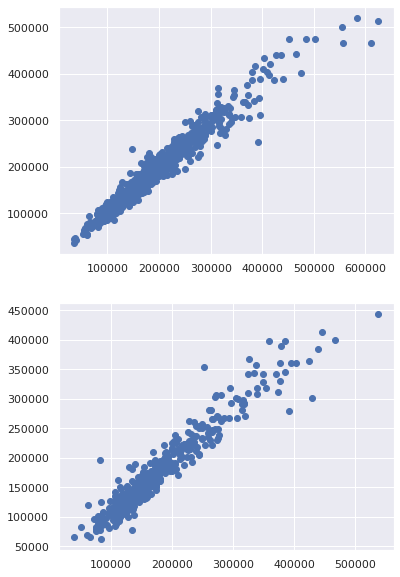

In [ ]:
plt.figure(figsize=(6,10))
plt.subplot(211)
plt.scatter(np.exp(y_train),np.exp(xgboost_opt.predict(X_train)))
plt.subplot(212)
plt.scatter(np.exp(y_test),np.exp(xgboost_opt.predict(X_test)))

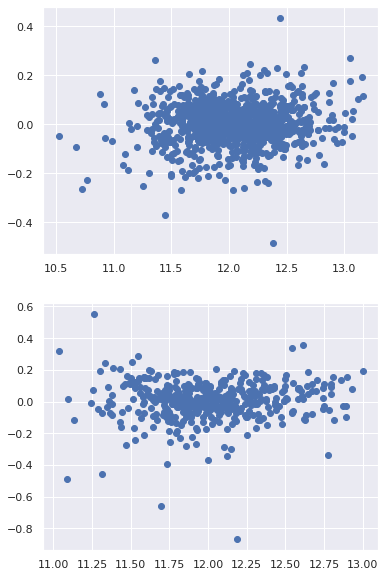

In [ ]:
# 残差プロット
plt.figure(figsize=(6,10))
plt.subplot(211)
plt.scatter(y_pred_train, y_train - y_pred_train)

plt.subplot(212)
plt.scatter(y_pred_test, y_test - y_pred_test)
plt.show()
#大体5千円の誤差に収まっているが、家賃の予測として大丈夫か
#➡(10,-1.5)の点があるがこれは外れ値ではないか、事故物件化どうかの確認ができるならして取り除くのもあり

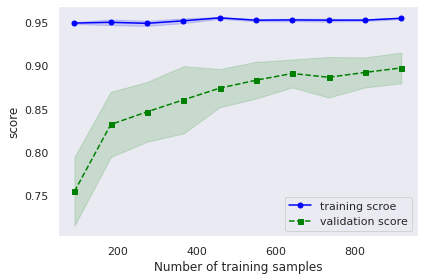

In [ ]:
  pipe_lr = make_pipeline(xgboost_opt)
  learning_curve_plot(pipe_lr,X_train,y_train)

### ファイブモデル作成(xgboost)

In [ ]:
SEED = 42
N_FOLDS = 5
# N_CLASS = 5　⇒分類
# MODEL_SAVE_DIR = 'drive/My Drive/rakus_cup/models'
# CSV_SAVE_DIR = 'drive/My Drive/rakus_cup/pred_csv'
# PREDICTION_NO = '01'
# TEAM_NAME = 'rakuraku-seisan-tsukaizurai'
PARAM = final_params2

In [ ]:
def run1(X_train,y_train,test_data,PARAM):
    import time
    # seed_everything(SEED)
    # os.environ.pop('PYTHONHASHSEED')
    # path_conf(MODEL_SAVE_DIR)
    oof = np.zeros(X_train.shape[0])
    pred = np.zeros(test_data.shape[0])
    # skf = StratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)
    kf = KFold(n_splits=N_FOLDS, random_state=SEED,shuffle=True)
    for i, (tr_ix, va_ix) in enumerate(kf.split(X_train, y_train)):
        print(f'===== Fold {i+1}/{N_FOLDS}    Start =====\n')
        start_time = time.time()
        X_tr, y_tr = X_train.iloc[tr_ix, :], y_train.iloc[tr_ix]
        X_va, y_va = X_train.iloc[va_ix, :], y_train.iloc[va_ix]

        # tra_dataset = lgb.Dataset(X_tr, y_tr)
        # val_dataset = lgb.Dataset(X_va, y_va)
        tra_dataset = xgb.DMatrix(X_tr,y_tr)
        val_dataset = xgb.DMatrix(X_va,y_va)
        test_dataset = xgb.DMatrix(test_data)

        evals = [(tra_dataset, 'train'), (val_dataset, 'eval')]
        evals_result = {}

        model = xgb.train(PARAM,
                         tra_dataset,
                         num_boost_round=10000,
                         early_stopping_rounds=30,
                         evals=evals,
                         evals_result=evals_result,
                         verbose_eval=False)
        oof[va_ix] = model.predict(val_dataset)
        pred += model.predict(test_dataset) / kf.n_splits

        #score➡交差検証のテストデータに対する、スコア＝n_splits個
        val_score_MSE = mean_squared_error(y_va, oof[va_ix])
        val_score_r2 = r2_score(y_va, oof[va_ix])
        print(f'Validation Score(MSE): {val_score_MSE:.3f}\n')
        print(f'Validation Score(R2): {val_score_r2:.3f}\n')

        end_time = time.time()
        print(f'timer:  {(end_time - start_time):.3f} sec.\n')


        # future_impotance_plots
        # _, ax = plt.subplots(figsize=(10, 30))
        # xgb.plot_importance(model, ax=ax, importance_type="gain", show_values=False)
        # plt.show()

        

        # with open(os.path.join(MODEL_SAVE_DIR, f'model_{i+1}.pkl'), 'wb') as f:
        #     pickle.dump(model, f)
            
    val_score_MSE = mean_squared_error(y_train, oof)
    val_score_r2 = r2_score(y_train, oof)
    print(f'\n\nTotal Validation Score(MSE): {val_score_MSE:.3f}\n')
    print(f'\n\nTotal Validation Score(R2): {val_score_r2:.3f}\n')
            
    return oof, pred

In [ ]:
oof ,test_predict = run1(X_kfold,y_kfold,test_data,PARAM)

===== Fold 1/5    Start =====

Validation Score(MSE): 0.015

Validation Score(R2): 0.909

timer:  0.663 sec.

===== Fold 2/5    Start =====

Validation Score(MSE): 0.016

Validation Score(R2): 0.893

timer:  0.833 sec.

===== Fold 3/5    Start =====

Validation Score(MSE): 0.015

Validation Score(R2): 0.896

timer:  0.512 sec.

===== Fold 4/5    Start =====

Validation Score(MSE): 0.017

Validation Score(R2): 0.899

timer:  0.810 sec.

===== Fold 5/5    Start =====

Validation Score(MSE): 0.015

Validation Score(R2): 0.907

timer:  0.909 sec.



Total Validation Score(MSE): 0.015



Total Validation Score(R2): 0.901



### ファイブモデルの作成(ElasticNet)

In [ ]:
SEED = 42
N_FOLDS = 5
# N_CLASS = 5　⇒分類
# MODEL_SAVE_DIR = 'drive/My Drive/rakus_cup/models'
# CSV_SAVE_DIR = 'drive/My Drive/rakus_cup/pred_csv'
# PREDICTION_NO = '01'
# TEAM_NAME = 'rakuraku-seisan-tsukaizurai'
# PARAM = {'alpha': 0.1, 'l1_ratio': 0.1}

In [ ]:
def run2(X_train,y_train,test_data,PARAM):
    import time
    # seed_everything(SEED)
    # os.environ.pop('PYTHONHASHSEED')
    # path_conf(MODEL_SAVE_DIR)

    oof = np.zeros(X_train.shape[0])
    pred = np.zeros(test_data.shape[0])
    # skf = StratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)
    kf = KFold(n_splits=N_FOLDS, random_state=SEED,shuffle=True)
    for i, (tr_ix, va_ix) in enumerate(kf.split(X_train, y_train)):
        print(f'===== Fold {i+1}/{N_FOLDS}    Start =====\n')
        start_time = time.time()
        X_tr, y_tr = X_train.iloc[tr_ix, :], y_train.iloc[tr_ix]
        X_va, y_va = X_train.iloc[va_ix, :], y_train.iloc[va_ix]

        sc = StandardScaler()
        X_tr = sc.fit_transform(X_tr)
        X_va = sc.fit_transform(X_va)
        # y_train = StandardScaler().fit(y_train)
        test_data = sc.fit_transform(test_data)

        model = ElasticNet(alpha= 0.1, l1_ratio =  0.1)
        model.fit(X_tr,y_tr)
        oof[va_ix] = model.predict(X_va)
        pred += model.predict(test_data) / kf.n_splits

        #score➡交差検証のテストデータに対する、スコア＝n_splits個
        val_score_MSE = mean_squared_error(y_va, oof[va_ix])
        val_score_r2 = r2_score(y_va, oof[va_ix])
        print(f'Validation Score(MSE): {val_score_MSE:.3f}\n')
        print(f'Validation Score(R2): {val_score_r2:.3f}\n')

        end_time = time.time()
        print(f'timer:  {(end_time - start_time):.3f} sec.\n')


        # future_impotance_plots
        # _, ax = plt.subplots(figsize=(10, 30))
        # xgb.plot_importance(model, ax=ax, importance_type="gain", show_values=False)
        # plt.show()

        

        # with open(os.path.join(MODEL_SAVE_DIR, f'model_{i+1}.pkl'), 'wb') as f:
        #     pickle.dump(model, f)
            
    val_score_MSE = mean_squared_error(y_train, oof)
    val_score_r2 = r2_score(y_train, oof)
    print(f'\n\nTotal Validation Score(MSE): {val_score_MSE:.3f}\n')
    print(f'\n\nTotal Validation Score(R2): {val_score_r2:.3f}\n')
            
    return oof, pred

In [ ]:
oof ,test_predict = run2(X_kfold,y_kfold,test_data,PARAM)

===== Fold 1/5    Start =====

Validation Score(MSE): 0.017

Validation Score(R2): 0.899

timer:  0.044 sec.

===== Fold 2/5    Start =====

Validation Score(MSE): 0.034

Validation Score(R2): 0.765

timer:  0.041 sec.

===== Fold 3/5    Start =====

Validation Score(MSE): 0.023

Validation Score(R2): 0.843

timer:  0.042 sec.

===== Fold 4/5    Start =====

Validation Score(MSE): 0.015

Validation Score(R2): 0.910

timer:  0.041 sec.

===== Fold 5/5    Start =====

Validation Score(MSE): 0.014

Validation Score(R2): 0.908

timer:  0.044 sec.



Total Validation Score(MSE): 0.021



Total Validation Score(R2): 0.868



# 5.提出用データの作成

In [ ]:
# 提出用データ生成
test_predict = np.exp(test_predict)
test_target = pd.DataFrame(test_predict,columns=[target])
test_Id = pd.DataFrame(test_id,columns=['Id'])
pd.concat([test_Id, test_target],axis=1).to_csv('output1.csv',index=False)

関数

In [ ]:
# 提出用データ生成関数
def sub(model,file_name,test_data,test_id): 
  test_predict = np.exp(model.predict(test_data))
  test_target = pd.DataFrame(test_predict,columns=[target])
  test_Id = pd.DataFrame(test_id,columns=['Id'])
  pd.concat([test_Id, test_target],axis=1).to_csv(file_name,index=False)

In [ ]:
sub(xgboost_opt,"output_3.csv",test_data,test_id)